## Import

In [1]:
# -*- coding: utf-8 -*-
import random
import pandas as pd
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torchvision.models as models

from tqdm.auto import tqdm
import random
import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Hyperparameter Setting

In [3]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':15,
    'LEARNING_RATE':3e-4, # default = 3e-4(0.0003)
    'BATCH_SIZE':32,
    'SEED':42,
    'BETA':1.0
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [5]:
df = pd.read_csv('/kaggle/input/dacon-data/train.csv')
df.head()

,img_id,img_path,airplane,airport,bare soil,baseball diamond,basketball court,beach,bridge,buildings,...,tanks,tennis court,terrace,track,trail,transmission tower,trees,water,wetland,wind turbine
0,000L8TYE,./train/000L8TYE.jpg,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
1,0035QTK9,./train/0035QTK9.jpg,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,00470HEH,./train/00470HEH.jpg,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,004CCB2Q,./train/004CCB2Q.jpg,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,005AY4ES,./train/005AY4ES.jpg,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0


## Train / Validation Split

In [6]:
df = df.sample(frac=1)
train_len = int(len(df) * 0.8)
train_df = df[:train_len]
val_df = df[train_len:]

In [7]:
(train_df.shape, val_df.shape)

((52396, 62), (13100, 62))

## Data Preprocessing

In [8]:
def get_labels(df):
    return df.iloc[:,2:].values

train_labels = get_labels(train_df)
val_labels = get_labels(val_df)

In [9]:
(train_labels.shape, val_labels.shape)

((52396, 60), (13100, 60))

## CustomDataset

In [10]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transform=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]

        # PIL 이미지로 불러오기
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        
        if self.label_list is not None:
            label = torch.tensor(self.label_list[index], dtype=torch.float32)
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [12]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),-
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE']), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE']), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
train_dataset = CustomDataset('/kaggle/input/dacon-data/'+train_df['img_path'].values, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=2)

val_dataset = CustomDataset('/kaggle/input/dacon-data/'+val_df['img_path'].values, val_labels, test_transform)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

## Cutmix Augmentation

In [14]:
def rand_bbox(size, lam): # size : [B, C, W, H]
    W = size[2] # 이미지의 width
    H = size[3] # 이미지의 height
    cut_rat = np.sqrt(1. - lam)  # 패치 크기의 비율 정하기
    cut_w = int(W * cut_rat)  # 패치의 너비
    cut_h = int(H * cut_rat)  # 패치의 높이

    # uniform
    # 기존 이미지의 크기에서 랜덤하게 값을 가져옵니다.(중간 좌표 추출)
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # 패치 부분에 대한 좌표값을 추출합니다.
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


In [15]:
X,y = next(iter(train_loader))
X = X.to(device)

lam = np.random.beta(1.0, 1.0)  # 베타 분포에서 lam 값을 가져옵나다.
rand_index = torch.randperm(X.size()[0]).to(device) # batch_size 내의 인덱스가 랜덤하게 셔플됩니다.

print(lam)
print(rand_index)

0.6947686574002817
tensor([10, 19, 12, 30, 18,  7,  0, 21,  6, 31, 23, 27, 11,  5, 17,  1, 13, 28,
        25, 20,  9, 16,  8, 22, 15,  2, 26,  4, 24,  3, 14, 29],
       device='cuda:0')


0.7641501913265306


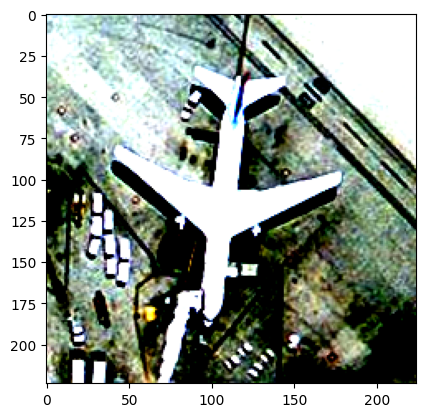

In [16]:
import matplotlib.pyplot as plt

bbx1, bby1, bbx2, bby2 = rand_bbox(X.size(), lam)
#X[:,:,bbx1:bbx2, bby1:bby2] = X[rand_index,:,bbx1:bbx2, bby1:bby2]
lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (X.size()[-1] * X.size()[-2]))
print(lam)
plt.imshow(X[0].permute(1, 2, 0).cpu())

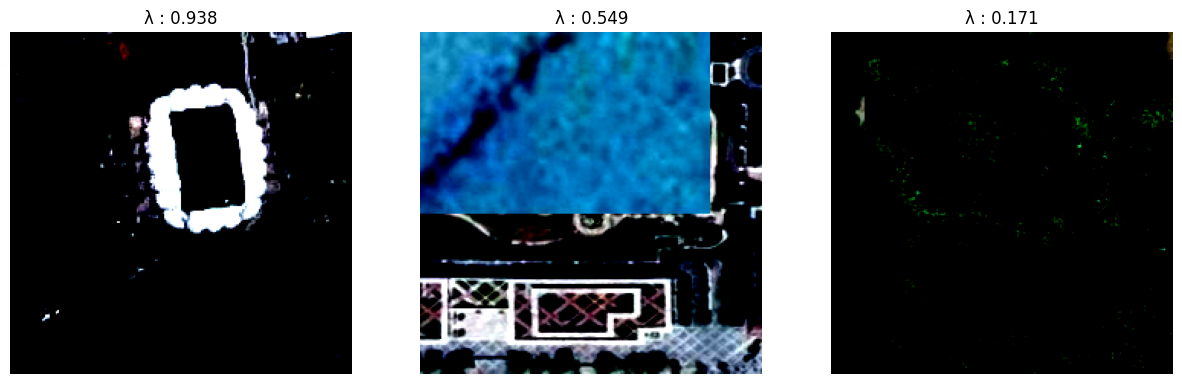

In [17]:
def cutmix_plot(train_loader):
    fig , axes = plt.subplots(1,3)
    fig.set_size_inches(15,12)
    
    for i in range(3):
        for inputs, targets in train_loader:
            inputs = inputs
            targets = targets
            break

        lam = np.random.beta(1.0, 1.0) 
        rand_index = torch.randperm(inputs.size()[0])
        bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
        inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
        axes[i].imshow(inputs[1].permute(1, 2, 0).cpu())
        axes[i].set_title(f'λ : {np.round(lam,3)}')
        axes[i].axis('off')
    return

cutmix_plot(train_loader)

## Model Define

In [18]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=60):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b4(pretrained = True) #ImageNet pretrained
        #self.classifier = nn.Linear(1000, num_classes) #1
        
        self.classifier2 = nn.Sequential(nn.Linear(1000, 512),
                                         nn.ReLU(),
                                         nn.Dropout(0.1),
                                         nn.BatchNorm1d(512),
                                         nn.Linear(512, num_classes) 
                                        )
    def forward(self, x):
        x = self.backbone(x)
        
        x = (self.classifier2(x)) #2
        
        return x

## Focal Loss Implementation

In [19]:
class FocalLossV1(nn.Module):

    def __init__(self,
                 alpha=0.25,
                 gamma=2,#default = 2
                 reduction='mean'):
        super(FocalLossV1, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.crit = nn.BCEWithLogitsLoss()

    def forward(self, logits, label):
        '''
        Usage is same as nn.BCEWithLogits:
            >>> criteria = FocalLossV1()
            >>> logits = torch.randn(8, 19, 384, 384)
            >>> lbs = torch.randint(0, 2, (8, 19, 384, 384)).float()
            >>> loss = criteria(logits, lbs)
        '''
        probs = torch.sigmoid(logits)
        coeff = torch.abs(label - probs).pow(self.gamma).neg()
        log_probs = torch.where(logits >= 0,
                F.softplus(logits, -1, 50),
                logits - F.softplus(logits, 1, 50))
        log_1_probs = torch.where(logits >= 0,
                -logits + F.softplus(logits, -1, 50),
                -F.softplus(logits, 1, 50))
        loss = label * self.alpha * log_probs + (1. - label) * (1. - self.alpha) * log_1_probs
        loss = loss * coeff

        if self.reduction == 'mean':
            loss = loss.mean()
        if self.reduction == 'sum':
            loss = loss.sum()
        return loss

## Train

In [20]:
def train(model, optimizer, scheduler, train_loader, val_loader, device):
    model.to(device)
    #criterion = nn.BCELoss().to(device)
    criterion = FocalLossV1().to(device)
    
    best_val_loss = float('inf') 
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            if CFG["BETA"] > 0 and np.random.random()>0.7: # cutmix 작동될 확률      
                lam = np.random.beta(CFG["BETA"], CFG["BETA"])
                rand_index = torch.randperm(imgs.size()[0]).to(device)
                target_a = labels
                target_b = labels[rand_index]            
                bbx1, bby1, bbx2, bby2 = rand_bbox(imgs.size(), lam)
                imgs[:, :, bbx1:bbx2, bby1:bby2] = imgs[rand_index, :, bbx1:bbx2, bby1:bby2]
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (imgs.size()[-1] * imgs.size()[-2]))
                output = model(imgs)
                loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
            
            else:
                output = model(imgs)
                loss = criterion(output, labels)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss.append(loss.item())
                    
        _val_loss = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')
            
        if best_val_loss > _val_loss:
            best_val_loss = _val_loss
            best_model = model
    
    return best_model

In [21]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            probs = model(imgs)
            
            loss = criterion(probs, labels)
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
    
    return _val_loss

## Run!!

In [22]:
model = BaseModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['LEARNING_RATE'], betas=(0.9, 0.999), eps=1e-08, 
                              weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min = 1e-4)

infer_model = train(model, optimizer, scheduler, train_loader, val_loader, device)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 175MB/s] 


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.03379] Val Loss : [0.01045]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.01274] Val Loss : [0.00803]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.01112] Val Loss : [0.00704]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.01013] Val Loss : [0.00663]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.00941] Val Loss : [0.00608]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.00861] Val Loss : [0.00599]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.00842] Val Loss : [0.00577]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.00807] Val Loss : [0.00565]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.00773] Val Loss : [0.00619]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.00762] Val Loss : [0.00573]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.00710] Val Loss : [0.00528]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.00712] Val Loss : [0.00516]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.00684] Val Loss : [0.00543]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.00659] Val Loss : [0.00581]


  0%|          | 0/1638 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.00686] Val Loss : [0.00535]


## Inference

In [23]:
test = pd.read_csv('/kaggle/input/dacon-data/test.csv')

In [24]:
test_dataset = CustomDataset('/kaggle/input/dacon-data/'+test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [25]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            probs = model(imgs)

            probs  = probs.cpu().detach().numpy()
            predictions += probs.tolist()
    return predictions

In [26]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/1365 [00:00<?, ?it/s]

## Submission

In [27]:
submit = pd.read_csv('/kaggle/input/dacon-data/sample_submission.csv')

In [28]:
submit.iloc[:,1:] = preds
submit.head()

,img_id,airplane,airport,bare soil,baseball diamond,basketball court,beach,bridge,buildings,cars,...,tanks,tennis court,terrace,track,trail,transmission tower,trees,water,wetland,wind turbine
0,000TT5XV,-3.547001,-3.610392,-0.689314,-2.889021,-2.883947,-2.407474,-2.949083,-0.226993,-0.084796,...,-3.030967,-2.772238,-2.747887,-2.700453,-2.467967,-3.074723,-2.157503,0.953279,-2.451221,-3.425576
1,0013XXDH,-3.203009,-3.098094,-1.662122,-3.164427,-3.529746,-4.436736,-3.163446,-2.112853,-2.536234,...,-3.735012,-3.040534,-2.848044,-3.258219,-1.769848,-2.730285,0.816840,-2.268640,-3.329717,-3.612756
2,001Z4YNH,-4.160880,-4.443101,-0.569307,-2.376899,-3.808346,-4.099965,-3.551053,0.698287,0.976727,...,-3.388295,0.966799,-3.113417,-3.267698,-2.251965,-2.778944,1.797776,-2.064934,-4.073026,-3.956786
3,00297F36,-3.592402,-3.394305,-1.388282,-3.289416,-2.957316,-4.024415,-2.984179,1.220760,0.970916,...,-0.982039,-1.134694,-0.795116,-1.172806,-0.758139,-0.992437,1.429819,-1.987549,-3.664405,-4.514473
4,002GFJL0,-3.320673,-3.295902,-0.432749,-2.672233,-2.614305,-4.356670,-2.951648,1.133708,0.369981,...,-2.501035,-2.181401,-2.432635,-2.033690,-2.107144,-2.727409,-1.096223,0.313154,-3.746626,-4.058338


In [29]:
submit.to_csv('/kaggle/working/model_4.csv', index=False)

In [30]:
# 모델 가중치 저장
torch.save(infer_model.state_dict(), 'model_4_weights.pth')

import numpy as np
from IPython.display import FileLink
import os

np.save("/kaggle/working/embedding",submit)
os.chdir(r'/kaggle/working')
FileLink(r'model_4_weights.pth') #링크로 따로 저장 용도

/kaggle/working/model_4_weights.pth